## Problem 1: Join accessibility datasets into a grid and visualise the data on a map (10 points)

![P1 example result](images/travel_times_example_720x720px.png)

*Sample result: Travel times by public transport (PT) and car to Itis and Myyrmanni*

Your task in *problem 1* is to combine data from non-spatial data sets (travel times between places)
and a spatial data set (grid cells that represent the places), and plot the combined data set to
visualise the travel times to two shopping centres from every other place in the Helsinki metropolitan
area. 

In particular, this task comprises of three major steps:

1. Read the grid cell data set
2. Read a travel time data set,
    - discard unnecessary columns,
    - rename the relevant columns to include a reference to the respective shopping centre,
    - join the relevant columns to the grid data set
3. Classify the travel times for both travel modes (public transport and private car) into five-minute intervals 

Repeat the second step for each of the two shopping centres (Itis, Myyrmanni).


---

### a) Read the grid cell data set (1 points)

The grid cells are derived from the ‘YKR’ data set, that is [published by the Finnish Environmental Institute
(SYKE)](https://www.ymparisto.fi/fi-fi/elinymparisto_ja_kaavoitus/yhdyskuntarakenne/tietoa_yhdyskuntarakenteesta/yhdyskuntarakenteen_seurannan_aineistot)
and collects a variety of indicators relating to the social and built-up structure of the country. In
an effort to harmonise different data products of other institutions, the YKR grid cell data set has
become a reference for many data products, including, for instance, the [travel time data set produced
at the Digital Geography Lab](https://blogs.helsinki.fi/accessibility/helsinki-region-travel-time-matrix/).

You can find the YKR data set in the directory `data` in *GeoPackage* format: `YKR_grid_EPSG3067.gpkg`.
It contains a polygon geometry column, and an (integer) identifier: `YKR_ID`.

Load the data into a `geopandas.GeoDataFrame` and call it `grid`.

In [1]:
import pathlib 
NOTEBOOK_PATH = pathlib.Path().resolve()
DATA_DIRECTORY = NOTEBOOK_PATH / "data"

In [2]:
import geopandas as gpd

grid = gpd.read_file(DATA_DIRECTORY / "YKR_grid_EPSG3067.gpkg")

grid.head()

,YKR_ID,geometry
0,5785640,"POLYGON ((382000 6697750, 381750 6697750, 3817..."
1,5785641,"POLYGON ((382250 6697750, 382000 6697750, 3820..."
2,5785642,"POLYGON ((382500 6697750, 382250 6697750, 3822..."
3,5785643,"POLYGON ((382750 6697750, 382500 6697750, 3825..."
4,5787544,"POLYGON ((381250 6697500, 381000 6697500, 3810..."



---

### b) Read the travel time data sets and join them to the grid cells (2 points)

Inside the `data` directory, you will find a set of semicolon-separated text files with travel times 
to each of a set of shopping centres in the Helsinki region (*this exercise was conceived before
REDI and Tripla started operation*).

The individual files have file names following the schema `travel_times_to_[XXXXX]_[Shopping_Centre]`, where
`[Shopping_Centre]` is the name of one of the seven shopping centres included in the data set, and `[XXXXX]`,
coincidently, referring to the YKR grid cell in which the shopping centre is located (although you should not
need to use this ID in this exercise).

The data sets contain computed travel times between different places in the metropolitan area. In order to 
produce such a *travel time matrix*, all connections from all origins to all destinations are calculated,
and then recorded in a table. 

#### Columns

The data sets we use have many **columns**, but only a few are interesting for this task:

- `from_id`: the `YKR_ID` of the *origin* grid cell
- `to_id`: refers to the `YKR_ID` of the *destination* grid cell (here: the one containing the shopping centre).
- `pt_r_t`: how long does it take to travel from `from_id` to `to_id`, in minutes, using public transport?
- `car_r_t`: how long does it take to drive a car from `from_id` to `to_id`, in minutes?

Note that `from_id` and `to_id` relate to the YKR `grid` data set’s `YKR_ID` column. Each input data set has only
one unique `to_id`, as the data has been split up to relate to one destination (a shopping centre), only, but many
unique values for `from_id`, as it covers the travel times from anywhere in the metropolitan area.

#### No-data values

The travel time data set contains some origin-destination pairs (*O/D-pairs*) for which it could not find a
public transport connection, or which are not accessible by car. Such **no-data values** are saves as 
`-1` minutes travel time. Use the [`pandas.Series.replace()`](https://pandas.pydata.org/docs/reference/api/pandas.Series.replace.html)
method to replace `-1` with `numpy.nan` to indicate that these cells do not contain valid data.


**IMPORTANT**: While we are having this course, a bug (https://github.com/pandas-dev/pandas/issues/45725)
prevents `pandas.Series.replace()` from working as expected: the line `travel_times["car_r_t"] = travel_times["car_r_t"].replace(-1, numpy.nan)`
fails with a `RecursionError`. There is a workaround: using an alternative syntax, using a `dict` of *before*
and *after* values, similar to how `pandas.DataFrame.rename()` works, does not trigger the issue. 
`travel_times["car_r_t"] = travel_times["car_r_t"].replace({-1: numpy.nan})` works.

---

Read the data sets for the shopping centres ‘Itis’ and ‘Myyrmanni’, discard irrelevant columns, rename the
`pt_r_t` and `car_r_t` columns to include a reference to the shopping centre (e.g., into `pt_r_t_Itis`), and join
the renamed columns to the `grid` data frame. Don’t forget to replace no-data values (`-1`) with `None`.

In [3]:
# Use glob() pattern search functionality to find files
# NOTE: glob() returns an iterator
list(DATA_DIRECTORY.glob("travel_times_to_*"))

[WindowsPath('C:/Users/Steph/Documents/autogis_23/autogis-ex4-neesteph/data/travel_times_to_5878070_Jumbo.txt'),
 WindowsPath('C:/Users/Steph/Documents/autogis_23/autogis-ex4-neesteph/data/travel_times_to_5878087_Dixi.txt'),
 WindowsPath('C:/Users/Steph/Documents/autogis_23/autogis-ex4-neesteph/data/travel_times_to_5902043_Myyrmanni.txt'),
 WindowsPath('C:/Users/Steph/Documents/autogis_23/autogis-ex4-neesteph/data/travel_times_to_5944003_Itis.txt'),
 WindowsPath('C:/Users/Steph/Documents/autogis_23/autogis-ex4-neesteph/data/travel_times_to_5975373_Forum.txt'),
 WindowsPath('C:/Users/Steph/Documents/autogis_23/autogis-ex4-neesteph/data/travel_times_to_5978593_Iso_Omena.txt'),
 WindowsPath('C:/Users/Steph/Documents/autogis_23/autogis-ex4-neesteph/data/travel_times_to_5980260_Ruoholahti.txt')]

In [4]:
# Save filenames into new variables based on index of list
itis_fp = list(DATA_DIRECTORY.glob("travel_times_to_*"))[3]
myyrmanni_fp = list(DATA_DIRECTORY.glob("travel_times_to_*"))[2]

In [5]:
import pandas as pd
import numpy as np

# Read txt file for Itis
itis_data = pd.read_csv(itis_fp, sep=';')

# Replace no-data values w/ NaN
itis_data = itis_data.replace(-1, np.nan)

# Discard irrelevant columns
itis_data = itis_data[["from_id", "to_id", "pt_r_t", "car_r_t"]]

# Rename columns to include reference to shopping centre
# Column to_id also renamed due to conflict when joining
    # ValueError: columns overlap but no suffix specified: Index(['to_id'], dtype='object')
itis_data = itis_data.rename(
    columns={
        "to_id": "to_id_Itis",
        "pt_r_t": "pt_r_t_Itis",
        "car_r_t": "car_r_t_Itis"
    }
)

itis_data.head()

,from_id,to_id_Itis,pt_r_t_Itis,car_r_t_Itis
0,5785640,5944003.0,132.0,50.0
1,5785641,5944003.0,135.0,51.0
2,5785642,5944003.0,137.0,58.0
3,5785643,5944003.0,141.0,57.0
4,5787544,5944003.0,125.0,50.0


In [6]:
# Read txt file for Myyrmanni
myyr_data = pd.read_csv(myyrmanni_fp, sep=';')

# Replace no-data values w/ NaN
myyr_data = myyr_data.replace(-1, np.nan)

# Discard irrelevant columns
myyr_data = myyr_data[["from_id", "to_id", "pt_r_t", "car_r_t"]]

# Rename columns to include reference to shopping centre
myyr_data = myyr_data.rename(
    columns={
        "to_id": "to_id_Myyrmanni",
        "pt_r_t": "pt_r_t_Myyrmanni",
        "car_r_t": "car_r_t_Myyrmanni"
    }
)

myyr_data.head()

,from_id,to_id_Myyrmanni,pt_r_t_Myyrmanni,car_r_t_Myyrmanni
0,5785640,5902043.0,90.0,39.0
1,5785641,5902043.0,93.0,39.0
2,5785642,5902043.0,95.0,47.0
3,5785643,5902043.0,99.0,51.0
4,5787544,5902043.0,83.0,38.0


In [7]:
# For two df w/ the same index and length, use join() function
# For two gdf, use spatial join: .sjoin()
# For two df w/ common key attribute, use merge() function

# For two df w/ common key attribute but different column names, set the index of both to refer to the same column and use join() function

# Set indices
grid = grid.set_index("YKR_ID")
itis_data = itis_data.set_index("from_id")
myyr_data = myyr_data.set_index("from_id")

# Join df using join() function and specify how parameter
# Left: use calling frame’s index (or column if on is specified)
grid = grid.join(itis_data, how="left").join(myyr_data, how="left")

grid.head()

,geometry,to_id_Itis,pt_r_t_Itis,car_r_t_Itis,to_id_Myyrmanni,pt_r_t_Myyrmanni,car_r_t_Myyrmanni
YKR_ID,,,,,,,
5785640,"POLYGON ((382000 6697750, 381750 6697750, 3817...",5944003.0,132.0,50.0,5902043.0,90.0,39.0
5785641,"POLYGON ((382250 6697750, 382000 6697750, 3820...",5944003.0,135.0,51.0,5902043.0,93.0,39.0
5785642,"POLYGON ((382500 6697750, 382250 6697750, 3822...",5944003.0,137.0,58.0,5902043.0,95.0,47.0
5785643,"POLYGON ((382750 6697750, 382500 6697750, 3825...",5944003.0,141.0,57.0,5902043.0,99.0,51.0
5787544,"POLYGON ((381250 6697500, 381000 6697500, 3810...",5944003.0,125.0,50.0,5902043.0,83.0,38.0


In [8]:
# NON-EDITABLE TEST CELL
import geopandas
assert type(grid) == geopandas.geodataframe.GeoDataFrame, "Output should be a geodataframe."

In [9]:
# NON-EDITABLE TEST CELL
# Check that the merged output have (at least) the necessary columns
required_columns = ['pt_r_t_Itis', 'car_r_t_Itis', 'pt_r_t_Myyrmanni', 'car_r_t_Myyrmanni', 'geometry']

assert all(column in grid.columns for column in required_columns), "Couldn’t find all required columns."

In [10]:
# NON-EDITABLE TEST CELL
# Check that -1 values are not present in the columns
for shopping_centre in ("Itis", "Myyrmanni"):
    for column in ("car_r_t", "pt_r_t"):
        assert -1 not in grid[f"{column}_{shopping_centre}"], "NoData values (-1) should be removed from the data!"


---

### c) Classify the travel times into five-minute intervals (4 points)

Classify the travel times for both travel modes (public transport and private car) into five-minute intervals 
- Create a **[`mapclassify.UserDefined` classifier](https://github.com/pysal/mapclassify#userdefined)**,
  using these class breaks: `5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60`
- Apply the classifier to `pt_r_t_[ShoppingCentre]` and `car_r_t_[ShoppingCentre]` columns,
  and store the results to `pt_r_t_cl_[ShoppingCentre]` and `car_r_t_cl_[ShoppingCentre]` columns, respectively

*Note that these 12 class breaks will produce 13 classes (1 class break divides the data into two classes)*

In [21]:
# Use pd.dropna() function to remove rows w/ NaNs
# Default: axis=0 or ‘index’ (drop rows which contain missing values)
grid = grid.dropna()

In [49]:
import mapclassify

# Define class breaks (5 min intervals) as a list
class_breaks = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60]

# Apply mapclassify.UserDefined scheme to each column
# If working with multiple/complex datasets and for clarity, it is helpful to specify y parameter (otherwise, can do w/o "y=")
# Output will be table of intervals and corresponding count
pt_r_t_cl_Itis = mapclassify.UserDefined(y=grid["pt_r_t_Itis"], bins=class_breaks)
car_r_t_cl_Itis = mapclassify.UserDefined(y=grid["car_r_t_Itis"], bins=class_breaks)
pt_r_t_cl_Myyrmanni = mapclassify.UserDefined(y=grid["pt_r_t_Myyrmanni"], bins=class_breaks)
car_r_t_cl_Myyrmanni = mapclassify.UserDefined(y=grid["car_r_t_Myyrmanni"], bins=class_breaks)

In [50]:
# Apply classification to columns using .apply() function and assign output to new columns
# Output will be class numbers (1-12)
# Double square brackets preserve DataFrame structure; Single square brackets selects column as Series
grid["pt_r_t_cl_Itis"] = grid[["pt_r_t_Itis"]].apply(pt_r_t_cl_Itis)
grid["car_r_t_cl_Itis"] = grid[["car_r_t_Itis"]].apply(car_r_t_cl_Itis)
grid["pt_r_t_cl_Myyrmanni"] = grid[["pt_r_t_Myyrmanni"]].apply(pt_r_t_cl_Myyrmanni)
grid["car_r_t_cl_Myyrmanni"] = grid[["car_r_t_Myyrmanni"]].apply(car_r_t_cl_Myyrmanni)

In [51]:
grid.head()

,geometry,to_id_Itis,pt_r_t_Itis,car_r_t_Itis,to_id_Myyrmanni,pt_r_t_Myyrmanni,car_r_t_Myyrmanni,pt_r_t_cl_Itis,car_r_t_cl_Itis,pt_r_t_cl_Myyrmanni,car_r_t_cl_Myyrmanni
YKR_ID,,,,,,,,,,,
5785640,"POLYGON ((382000 6697750, 381750 6697750, 3817...",5944003.0,132.0,50.0,5902043.0,90.0,39.0,12,9,12,7
5785641,"POLYGON ((382250 6697750, 382000 6697750, 3820...",5944003.0,135.0,51.0,5902043.0,93.0,39.0,12,10,12,7
5785642,"POLYGON ((382500 6697750, 382250 6697750, 3822...",5944003.0,137.0,58.0,5902043.0,95.0,47.0,12,11,12,9
5785643,"POLYGON ((382750 6697750, 382500 6697750, 3825...",5944003.0,141.0,57.0,5902043.0,99.0,51.0,12,11,12,10
5787544,"POLYGON ((381250 6697500, 381000 6697500, 3810...",5944003.0,125.0,50.0,5902043.0,83.0,38.0,12,9,12,7


In [52]:
# NON-EDITABLE TEST CELL
# Check the output
print("travel times by public transport:")
grid[['pt_r_t_Itis', 'pt_r_t_cl_Itis']].head()

travel times by public transport:


,pt_r_t_Itis,pt_r_t_cl_Itis
YKR_ID,,
5785640,132.0,12
5785641,135.0,12
5785642,137.0,12
5785643,141.0,12
5787544,125.0,12


In [53]:
# NON-EDITABLE TEST CELL
# Check the output
print("Travel times by car:")
grid[["car_r_t_Myyrmanni", "car_r_t_cl_Myyrmanni"]].head()

Travel times by car:


,car_r_t_Myyrmanni,car_r_t_cl_Myyrmanni
YKR_ID,,
5785640,39.0,7
5785641,39.0,7
5785642,47.0,9
5785643,51.0,10
5787544,38.0,7


### d) Plot the classified travel times (3 points)

Create a 2⨉2 plot, in which you plot the *classified* travel times by public transport (left) and by car (right),
to Itis (top) and Myyrmanni (bottom):

- [Create subplots using `matplotlib.pyplot.subplots()`](https://geo-python-site.readthedocs.io/en/latest/notebooks/L7/advanced-plotting.html#using-subplots),
  with 2 rows and 2 columns. Increase the figure size to 10⨉10"
- Add appropriate titles for the subplots
- Save the figure to a file called `shopping_centre_accessibility.png` in the `DATA_DIRECTORY`


In [ ]:
# Plot
accessibility_grid.plot(column="nb_pt_r_tt", linewidth=0, legend=True)

yearly_data["winter"].plot(
    x = "YEAR",
    y = "diff",
    ax=ax11, 
    c="blue", 
    lw=line_width, 
    ylim=[-15, 15],
    ylabel="Temperature Anomaly [°C]",
    grid=True
)


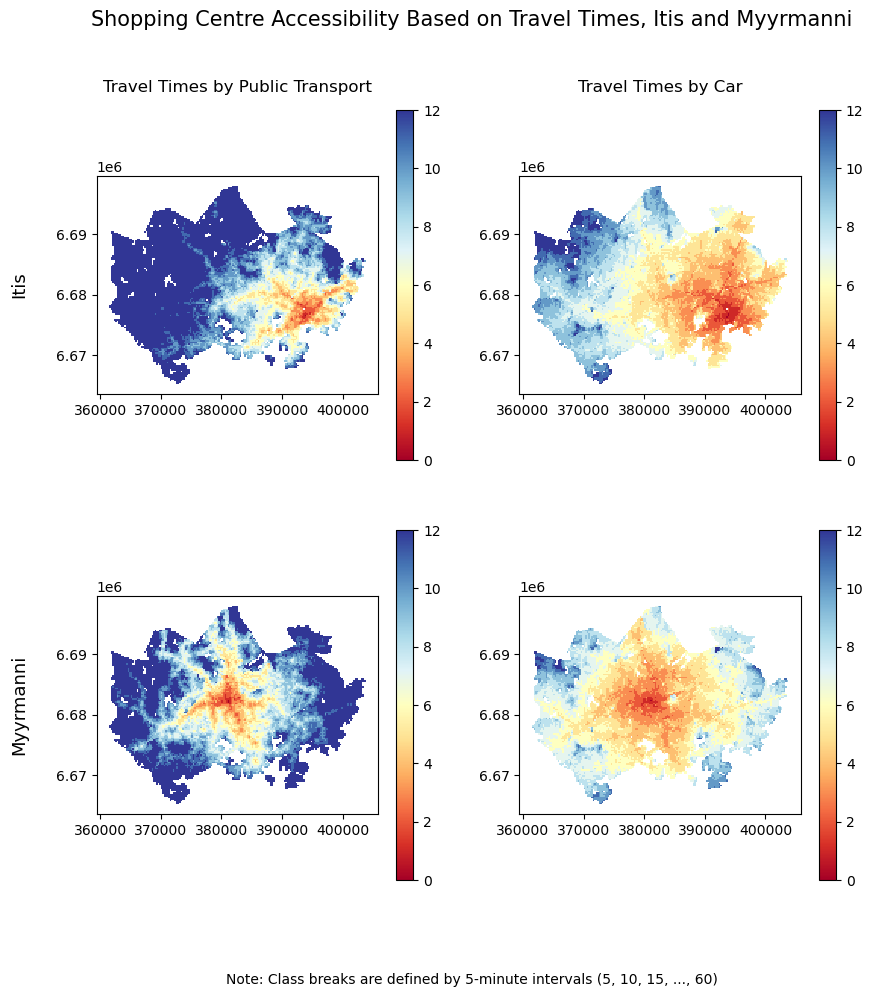

In [76]:
import matplotlib.pyplot as plt

# Create a figure containing four subplots in a 2x2 panel using the .subplots() function from matplotlib
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
axs

# Set figure title
fig.suptitle("Shopping Centre Accessibility Based on Travel Times, Itis and Myyrmanni", fontsize=15)

# To make it easier to keep track of things, parse these axes into their own variables
ax11 = axs[0][0]
ax12 = axs[0][1]
ax21 = axs[1][0]
ax22 = axs[1][1]

# Set subtitles, font size, padding (vdistance b/w plot and title)
ax11.set_title("Travel Times by Public Transport", pad=60)
ax12.set_title("Travel Times by Car", pad=60)
ax11.set_ylabel("Itis", fontsize=13, labelpad=20)
ax21.set_ylabel("Myyrmanni", fontsize=13, labelpad=20)

# Add caption at the bottom of the figure
fig.text(
    0.5,     # Horizontal positioning (x), center of fig
    0.01,    # Vertical positioning (y), bottom of fig
    "Note: Class breaks are defined by 5-minute intervals (5, 10, 15, ..., 60)", 
    ha='center',    # Horizontal alignment (text is centered)
    va='center',    # Vertical alignment
    fontsize=10
)

# Plot travel times
grid.plot(
    column="pt_r_t_cl_Itis",
    ax=ax11,
    linewidth=0,
    legend=True,
    cmap="RdYlBu"
)

grid.plot(
    column="car_r_t_cl_Itis",
    ax=ax12,
    linewidth=0,
    legend=True,
    cmap="RdYlBu"
)

grid.plot(
    column="pt_r_t_cl_Myyrmanni",
    ax=ax21,
    linewidth=0,
    legend=True,
    cmap="RdYlBu"
)

grid.plot(
    column="car_r_t_cl_Myyrmanni",
    ax=ax22,
    linewidth=0,
    legend=True,
    cmap="RdYlBu"
)

# Write figure to PNG file
plt.savefig(DATA_DIRECTORY / "shopping_centre_accessibility.png")

In [77]:
# NON-EDITABLE TEST CELL
# Check that output figure file exists
assert (DATA_DIRECTORY / "shopping_centre_accessibility.png").exists()


---

**Finally**, check that you have provided adequate comments in your code.

---

### Reflections

If you want to ask feedback on spesific parts of your code, please leave your comment here


---

### Done!

**Remember to commit the output figure** to your exercise repository!

That’s! Once you have plotted the data and saved the output, you are ready to proceed to *problem 2*.